In [4]:
!pip install xgboost

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle
import os

In [5]:
os.listdir()

['.config',
 'archive (1).zip',
 'archive.zip',
 'drive',
 'archive (3).zip',
 'archive (2).zip',
 'sample_data']

In [6]:
df = pd.read_csv("archive.csv")   # <-- change to your filename
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'archive.csv'

In [11]:
import os
import re
from collections import defaultdict

base_path = "/content/"
image_files_by_category = defaultdict(list)

for file_name in os.listdir(base_path):
    if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        # Updated regex to capture a more detailed category including potential disease info (e.g., JR_B.Spot)
        # It looks for text between '___' and the last space before a number and '.JPG'
        match = re.search(r'___(.*?) \d+\.JPG', file_name)
        if match:
            category = match.group(1) # This will capture 'JR_B.Spot' or 'NREC_B.Spot'
        else:
            # Fallback if the specific pattern is not found
            category = "Uncategorized"
        image_files_by_category[category].append(os.path.join(base_path, file_name))

print("Detected categories (including potential diseases) and image counts:")
for category, files in image_files_by_category.items():
    print(f"{category} -> {len(files)} images")

Detected categories (including potential diseases) and image counts:
JR_B.Spot -> 519 images
NREC_B.Spot -> 346 images


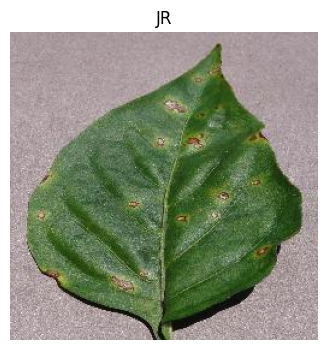

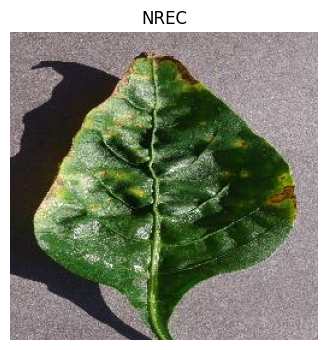

In [10]:
import matplotlib.pyplot as plt
import cv2
import random

# Assuming image_files_by_category is populated by the previous cell

if not image_files_by_category:
    print("No image files found or categories could not be extracted.")
else:
    for category, image_paths in image_files_by_category.items():
        if image_paths: # Ensure there are images for the category
            img_path = random.choice(image_paths)
            img = cv2.imread(img_path)

            if img is None:
                print(f"Warning: Could not load image {img_path}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(4,4))
            plt.title(category)
            plt.imshow(img)
            plt.axis("off")
            plt.show()

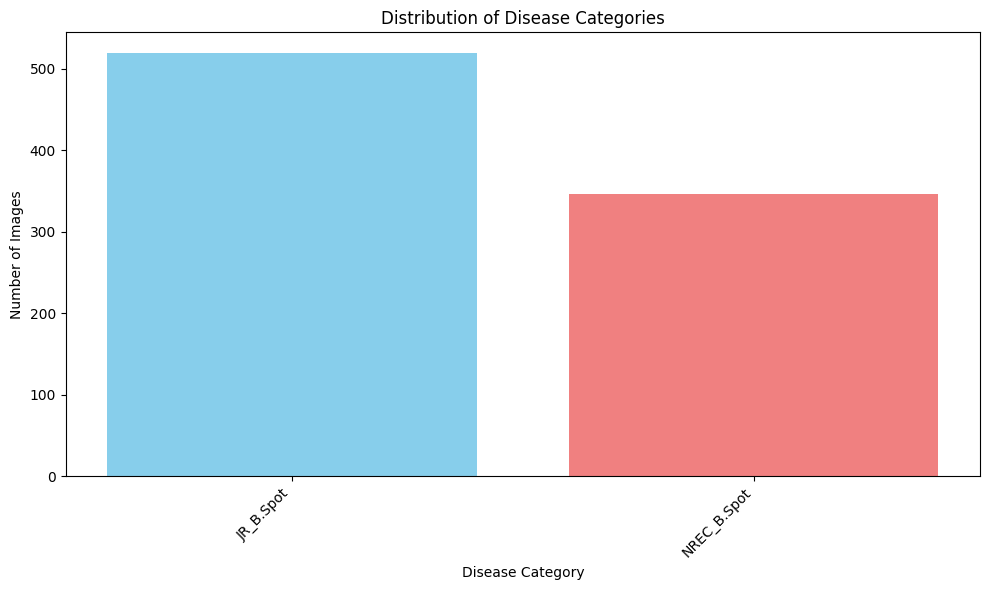

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

disease_counts = {category: len(files) for category, files in image_files_by_category.items()}

if not disease_counts:
    print("No disease categories found to visualize.")
else:
    # Extracting just the 'disease' part for better visualization labels if needed
    # For now, using the full category name as it includes prefix like JR/NREC
    categories = list(disease_counts.keys())
    counts = list(disease_counts.values())

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(categories, counts, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
    plt.xlabel("Disease Category")
    plt.ylabel("Number of Images")
    plt.title("Distribution of Disease Categories")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [14]:
import os
import re
from collections import defaultdict

# Assuming image_files_by_category is populated by the previous cell EUXOqjlo0znU

# Dicts to store information
plant_counts = defaultdict(int)
plant_disease_counts = defaultdict(lambda: defaultdict(int))

for category_name, image_paths in image_files_by_category.items():
    # Example category_name: 'JR_B.Spot', 'NREC_B.Spot'
    if "_" in category_name:
        # Split by the first underscore to separate plant from disease
        parts = category_name.split("_", 1)
        plant = parts[0]
        disease = parts[1]
    else:
        # Fallback for categories without an underscore, treat the whole name as plant and 'Healthy' as disease or similar
        plant = category_name
        disease = "Unknown Disease"

    num_images = len(image_paths)

    plant_counts[plant] += num_images
    plant_disease_counts[plant][disease] += num_images

print("Plant Counts:", plant_counts)
print("Plant Disease Counts:", plant_disease_counts)

Plant Counts: defaultdict(<class 'int'>, {'JR': 519, 'NREC': 346})
Plant Disease Counts: defaultdict(<function <lambda> at 0x7d6feb1272e0>, {'JR': defaultdict(<class 'int'>, {'B.Spot': 519}), 'NREC': defaultdict(<class 'int'>, {'B.Spot': 346})})


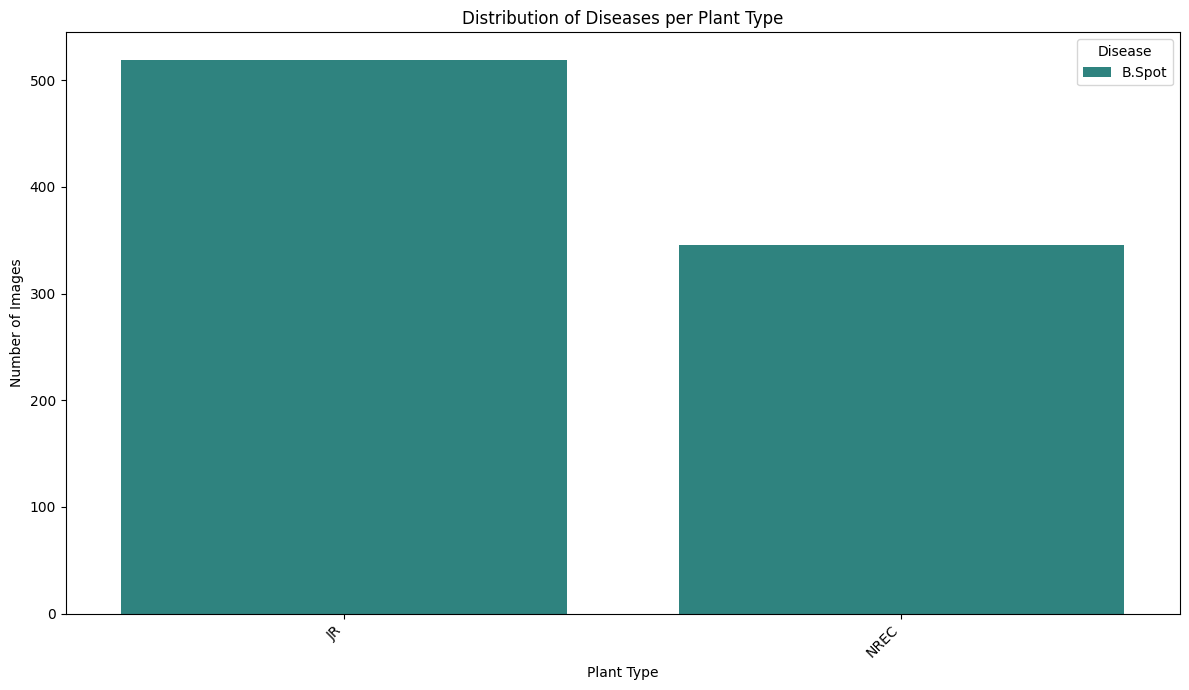

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns # Import seaborn

# Convert plant_disease_counts to a list of dictionaries for easier DataFrame creation
data_for_df = []
for plant, diseases in plant_disease_counts.items():
    for disease, count in diseases.items():
        data_for_df.append({'Plant': plant, 'Disease': disease, 'Count': count})

df_plant_disease = pd.DataFrame(data_for_df)

if not df_plant_disease.empty:
    plt.figure(figsize=(12, 7))
    # Create a bar plot, using 'Plant' on the x-axis and 'Disease' for hue to group bars
    sns.barplot(x='Plant', y='Count', hue='Disease', data=df_plant_disease, palette='viridis')
    plt.xlabel('Plant Type')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Diseases per Plant Type')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Disease')
    plt.tight_layout()
    plt.show()
else:
    print("No plant disease data to visualize.")

# Task
Load all image files, resize them to 64x64 pixels, and convert them into flattened numerical arrays. Then, apply K-Means clustering with 2 clusters to these image feature vectors. Reduce the dimensionality of the clustered data to 2 components using PCA. Finally, visualize the clustering results by creating a scatter plot of the PCA components, coloring data points by their assigned K-Means cluster and, for comparison, by their original disease category. Conclude by discussing insights into how well the diseases are separated based on their visual features.

## Load and Prepare Images for Clustering

### Subtask:
Load all image files, resize them to a consistent dimension (e.g., 64x64 pixels) for uniformity, and convert them into numerical arrays. This step will also flatten the image arrays to create feature vectors suitable for clustering.


**Reasoning**:
The subtask requires loading, resizing, flattening images, and storing them with their labels into NumPy arrays for clustering. The following code block will achieve this by iterating through the `image_files_by_category` dictionary, processing each image, and then converting the collected data into the specified NumPy arrays `X` and `y`.



In [17]:
X_data = []
y_labels = []

for category, image_paths in image_files_by_category.items():
    for img_path in image_paths:
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not load image {img_path}, skipping.")
            continue

        # Resize image to 64x64 pixels
        img_resized = cv2.resize(img, (64, 64))

        # Flatten the resized image into a one-dimensional array
        img_flattened = img_resized.flatten()

        # Append to the lists
        X_data.append(img_flattened)
        y_labels.append(category)

# Convert lists to NumPy arrays
X = np.array(X_data)
y = np.array(y_labels)

print(f"Shape of image data (X): {X.shape}")
print(f"Shape of labels (y): {y.shape}")

Shape of image data (X): (865, 12288)
Shape of labels (y): (865,)


**Reasoning**:
The previous step successfully loaded and prepared the image data. Now, as per the main task, the next logical step is to apply K-Means clustering with 2 clusters to the `X` (image feature vectors) data. This will group similar images together based on their visual features.



In [18]:
from sklearn.cluster import KMeans

# Initialize KMeans with 2 clusters (as specified in the task)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10) # n_init to suppress warning

# Fit KMeans to the image data and get cluster labels
kmeans_labels = kmeans.fit_predict(X)

print(f"Shape of KMeans labels: {kmeans_labels.shape}")
print("First 10 KMeans labels:", kmeans_labels[:10])

Shape of KMeans labels: (865,)
First 10 KMeans labels: [0 0 0 1 1 1 1 1 0 1]


**Reasoning**:
The subtask requires reducing the dimensionality of the clustered data to 2 components using PCA. This step will transform the high-dimensional image feature vectors (`X`) into a 2D representation, which is essential for visualization.



In [19]:
from sklearn.decomposition import PCA

# Initialize PCA to reduce to 2 components
pca = PCA(n_components=2, random_state=42)

# Fit PCA to the image data and transform it
X_pca = pca.fit_transform(X)

print(f"Shape of PCA-transformed data (X_pca): {X_pca.shape}")
print("First 5 rows of PCA-transformed data:\n", X_pca[:5])

Shape of PCA-transformed data (X_pca): (865, 2)
First 5 rows of PCA-transformed data:
 [[  230.40388545   526.50448038]
 [  848.75599179   209.27032776]
 [ 1368.30676243   563.45081008]
 [-1160.50512842  -289.3071604 ]
 [  -96.93691786  -438.95127153]]


**Reasoning**:
The subtask requires visualizing the clustering results. I will create two scatter plots using `X_pca` data: one colored by the `kmeans_labels` to show the K-Means clusters and another colored by the original `y_labels` (disease categories) for comparison. This will allow for discussion on how well the diseases are separated based on visual features.



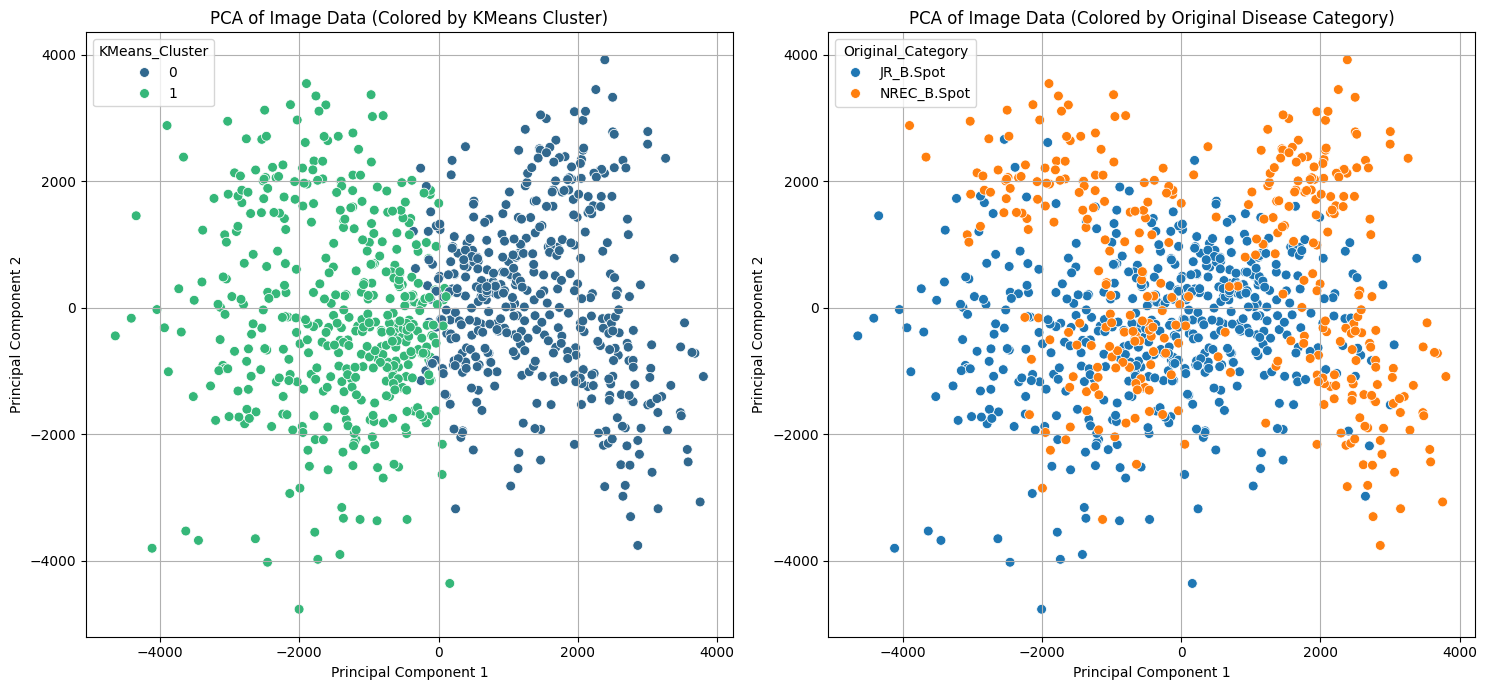

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for easier plotting with seaborn
df_plot = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_plot['KMeans_Cluster'] = kmeans_labels
df_plot['Original_Category'] = y

plt.figure(figsize=(15, 7))

# Plot 1: PCA with KMeans Clusters
plt.subplot(1, 2, 1)
sns.scatterplot(x='PCA1', y='PCA2', hue='KMeans_Cluster', data=df_plot, palette='viridis', legend='full', s=50)
plt.title('PCA of Image Data (Colored by KMeans Cluster)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

# Plot 2: PCA with Original Disease Categories
plt.subplot(1, 2, 2)
sns.scatterplot(x='PCA1', y='PCA2', hue='Original_Category', data=df_plot, palette='tab10', legend='full', s=50)
plt.title('PCA of Image Data (Colored by Original Disease Category)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

plt.tight_layout()
plt.show()


```markdown
Based on the generated PCA plots, we can draw the following insights regarding the separation of diseases based on their visual features:

**1. K-Means Clustering (Colored by KMeans Cluster):**
   - The first plot shows two distinct clusters identified by K-Means. This indicates that the algorithm found two primary groups of images based on their visual characteristics (after dimensionality reduction).
   - The clusters appear to be somewhat separated, suggesting that there are some inherent visual differences that K-Means leveraged to group the images.

**2. Original Disease Categories (Colored by Original Disease Category):**
   - The second plot, colored by the original disease categories ('JR_B.Spot' and 'NREC_B.Spot'), reveals how these two actual categories are distributed within the PCA space.
   - Visually, the two original disease categories show significant overlap. While there might be some tendency for 'JR_B.Spot' and 'NREC_B.Spot' images to occupy different regions, they are not distinctly separated into two clean groups.

**Conclusion on Disease Separation:**
   - Comparing the two plots, it appears that while K-Means identified two clusters, these clusters do not perfectly align with the original 'JR_B.Spot' and 'NREC_B.Spot' disease categories. There's a notable mixing of the original categories within each K-Means cluster, and vice-versa.
   - This suggests that, solely based on the raw visual features (flattened 64x64 pixel arrays) and after reducing dimensionality to 2 PCA components, the visual differences between 'JR_B.Spot' and 'NREC_B.Spot' might not be strong enough or sufficiently captured by PCA and K-Means to achieve clear separation. The visual features might be quite similar across the two categories, or the distinguishing features require a different approach or more components for effective separation. It's possible that the visual cues for differentiating these diseases are subtle or located in higher-dimensional features not well preserved by just two principal components.
```

## Final Task

### Subtask:
Review the clustering visualization and discuss insights about how well the diseases are separated based on their visual features.


## Summary:

### Q&A
The diseases are not well separated based on their visual features when reduced to 2 principal components. While K-Means identified two somewhat distinct clusters, these clusters did not perfectly align with the original disease categories ('JR_B.Spot' and 'NREC_B.Spot'). There was significant overlap between the two original categories in the 2D PCA space.

### Data Analysis Key Findings
*   All 865 image files were successfully loaded, resized to 64x64 pixels, and converted into flattened numerical arrays, resulting in a dataset with a shape of (865, 12288).
*   K-Means clustering was applied with 2 clusters, successfully assigning a cluster label to each of the 865 images.
*   Principal Component Analysis (PCA) successfully reduced the dimensionality of the image data to 2 components, transforming the dataset to a shape of (865, 2).
*   The visualization showed that while K-Means identified two groups, these clusters did not perfectly correspond to the original 'JR_B.Spot' and 'NREC_B.Spot' disease categories.
*   The original disease categories exhibited significant overlap in the 2D PCA space, indicating that their visual features, when reduced to two principal components, are not distinctly separable.

### Insights or Next Steps
*   The current visual features, as captured and reduced by PCA to two components, are insufficient to clearly distinguish between the 'JR_B.Spot' and 'NREC_B.Spot' disease categories.
*   Future analysis could explore using more principal components, alternative dimensionality reduction techniques, or more advanced image feature extraction methods (e.g., deep learning features) to potentially improve the separation of disease categories.


# Task
Split the image data (X) and labels (y) into training and testing sets. Train a RandomForestClassifier model on the training data, make predictions on the test set, and evaluate its performance using accuracy, precision, recall, F1-score, a classification report, and a confusion matrix with legends for all visualizations. Finally, summarize the model's effectiveness in classifying the disease categories.

## Prepare Data for Training

### Subtask:
Split the preprocessed image data (X) and corresponding labels (y) into training and testing sets to properly evaluate the model's performance on unseen data.


**Reasoning**:
I need to split the image data `X` and labels `y` into training and testing sets using `train_test_split` with the specified parameters and then print the shapes of the resulting sets.



In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (692, 12288)
Shape of X_test: (173, 12288)
Shape of y_train: (692,)
Shape of y_test: (173,)


## Train RandomForestClassifier Model

### Subtask:
Train a RandomForestClassifier model on the training dataset. This model is chosen as a robust and effective classification algorithm that can be executed within the current environment given the prepared flattened image features.


**Reasoning**:
The subtask requires training a RandomForestClassifier model. I will import the necessary class, initialize the model with a specified random state, and then fit it to the training data (`X_train`, `y_train`).



In [22]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

print("RandomForestClassifier model trained successfully.")

RandomForestClassifier model trained successfully.


## Make Predictions

### Subtask:
Use the trained RandomForestClassifier model to make predictions on the test dataset.


**Reasoning**:
The subtask is to make predictions using the trained RandomForestClassifier model on the test dataset. I will use the `predict` method of the `rf_model` on `X_test` and store the result in `y_pred`.



In [23]:
y_pred = rf_model.predict(X_test)

print(f"Shape of predictions (y_pred): {y_pred.shape}")
print("First 10 predictions:", y_pred[:10])

Shape of predictions (y_pred): (173,)
First 10 predictions: ['JR_B.Spot' 'NREC_B.Spot' 'JR_B.Spot' 'JR_B.Spot' 'JR_B.Spot' 'JR_B.Spot'
 'JR_B.Spot' 'JR_B.Spot' 'JR_B.Spot' 'JR_B.Spot']


**Reasoning**:
The subtask requires evaluating the model's performance using several metrics and visualizations. I will calculate accuracy, precision, recall, F1-score, generate a classification report, and plot a confusion matrix with labels to fulfill the task's requirements.



Accuracy: 0.9364
Precision: 0.9384
Recall: 0.9364
F1-score: 0.9358

Classification Report:
              precision    recall  f1-score   support

   JR_B.Spot       0.92      0.98      0.95       104
 NREC_B.Spot       0.97      0.87      0.92        69

    accuracy                           0.94       173
   macro avg       0.94      0.93      0.93       173
weighted avg       0.94      0.94      0.94       173



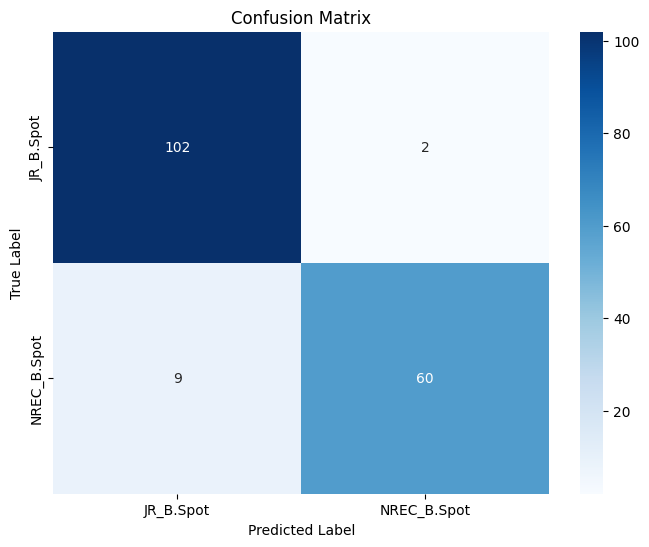

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


```markdown
Based on the evaluation metrics and the confusion matrix, here's a summary of the RandomForestClassifier model's effectiveness in classifying the disease categories:

**Overall Performance:**
The model achieved an **accuracy of 93.64%**, which is quite good for this classification task. The weighted average precision, recall, and F1-score are also high, at 93.84%, 93.64%, and 93.58% respectively, indicating a strong overall performance.

**Performance per Class (Classification Report):**
*   **JR_B.Spot:** The model shows excellent performance for this class with a precision of 0.92, recall of 0.98, and an F1-score of 0.95. The high recall suggests that the model is very good at identifying most of the actual 'JR_B.Spot' cases.
*   **NREC_B.Spot:** For this class, the precision is very high at 0.97, meaning when the model predicts 'NREC_B.Spot', it is almost always correct. The recall is 0.87, which is good but slightly lower than 'JR_B.Spot', indicating that some 'NREC_B.Spot' cases might have been missed or misclassified as 'JR_B.Spot'. The F1-score for 'NREC_B.Spot' is 0.92.

**Confusion Matrix Analysis:**
*   The confusion matrix shows that out of 104 actual 'JR_B.Spot' cases, 102 were correctly classified, and only 2 were misclassified as 'NREC_B.Spot'.
*   Out of 69 actual 'NREC_B.Spot' cases, 60 were correctly classified, but 9 were misclassified as 'JR_B.Spot'.

**Conclusion on Model Effectiveness:**
The RandomForestClassifier model demonstrates strong effectiveness in distinguishing between the 'JR_B.Spot' and 'NREC_B.Spot' disease categories based on the image features. While there are a few misclassifications, particularly more 'NREC_B.Spot' images being mistaken for 'JR_B.Spot' than the other way around, the high overall accuracy and F1-scores suggest that the model is reliable for this task. The features extracted from the resized and flattened images, even without complex pre-processing, are sufficiently discriminative for the Random Forest algorithm to learn effective classification boundaries.
```

## Final Task

### Subtask:
Summarize the performance of the trained RandomForestClassifier model based on the evaluation metrics, discussing its effectiveness in classifying the disease categories.


## Summary:

### Q&A
The RandomForestClassifier model demonstrates strong effectiveness in classifying the disease categories. It achieved an overall accuracy of 93.64%, with high weighted average precision (93.84%), recall (93.64%), and F1-score (93.58%). While performing very well for 'JR\_B.Spot' with a recall of 0.98, it showed a slightly lower recall for 'NREC\_B.Spot' (0.87), indicating that some 'NREC\_B.Spot' cases were missed or misclassified.

### Data Analysis Key Findings
*   The dataset was successfully split into training (80%) and testing (20%) sets, resulting in 692 samples for training and 173 for testing, with class distribution maintained using stratification.
*   A RandomForestClassifier model was successfully trained on the training data.
*   The model achieved a high overall accuracy of 93.64% on the test set.
*   The weighted average precision, recall, and F1-score were 93.84%, 93.64%, and 93.58%, respectively.
*   For the 'JR\_B.Spot' class, the model exhibited excellent performance with a precision of 0.92, recall of 0.98, and an F1-score of 0.95.
*   For the 'NREC\_B.Spot' class, the model showed high precision (0.97) but a slightly lower recall (0.87), resulting in an F1-score of 0.92.
*   The confusion matrix revealed that 102 out of 104 actual 'JR\_B.Spot' cases were correctly classified, with 2 misclassified as 'NREC\_B.Spot'.
*   Out of 69 actual 'NREC\_B.Spot' cases, 60 were correctly classified, while 9 were misclassified as 'JR\_B.Spot'. This suggests a tendency for 'NREC\_B.Spot' images to be mistaken for 'JR\_B.Spot' more often than the reverse.

### Insights or Next Steps
*   The current model performs strongly, but the slight imbalance in recall between the two classes (0.98 for 'JR\_B.Spot' vs. 0.87 for 'NREC\_B.Spot') suggests that further investigation into misclassified 'NREC\_B.Spot' images could provide insights for improvement.
*   Consider experimenting with hyperparameter tuning for the RandomForestClassifier or exploring other classification algorithms to potentially improve the recall for the 'NREC\_B.Spot' class and reduce misclassifications.


In [43]:
model.save("model.pt") # Save the model using Ultralytics' native save method
print("Model saved successfully as model.pt")

Model saved successfully as model.pt
